In [1]:
import numpy as np
import scipy.io
import mne
from mne_icalabel import label_components
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt

In [2]:
print("Step 1: Loading and Preprocessing Data...")

# Load and reshape
location = "/Users/anuraagsrivatsa/Documents/Capstone/EAV/EAV/subject1/EEG/subject1_eeg.mat"
data = scipy.io.loadmat(location)
eeg_data_reshaped = np.transpose(data['seg'], (2, 1, 0)) # (200, 30, 10000)

# Downsample'
downsampled = mne.filter.resample(eeg_data_reshaped, down=2, npad="auto") # (200, 30, 5000)

# Band-pass filter
SAMPLING_RATE_DOWNSAMPLED = 250
nyquist = 0.5 * SAMPLING_RATE_DOWNSAMPLED
low_norm = 1.0 / nyquist
high_norm = 45.0 / nyquist
b, a = butter(4, [low_norm, high_norm], btype='band')
filtered_data = filtfilt(b, a, downsampled, axis=-1)

preprocessed_data = filtered_data
print(f"Data shape after initial preprocessing: {preprocessed_data.shape}")

Step 1: Loading and Preprocessing Data...
Data shape after initial preprocessing: (200, 30, 5000)



Step 2: Converting data to MNE Epochs format...
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
<EpochsArray | 200 events (all good), -10 – 9.996 s (baseline off), ~228.9 MiB, data loaded,
 '1': 200>
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Common Average Reference (CAR) has been added as a projector.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
CAR projector has been applied to the data.
Plotting sensor locations for verification...


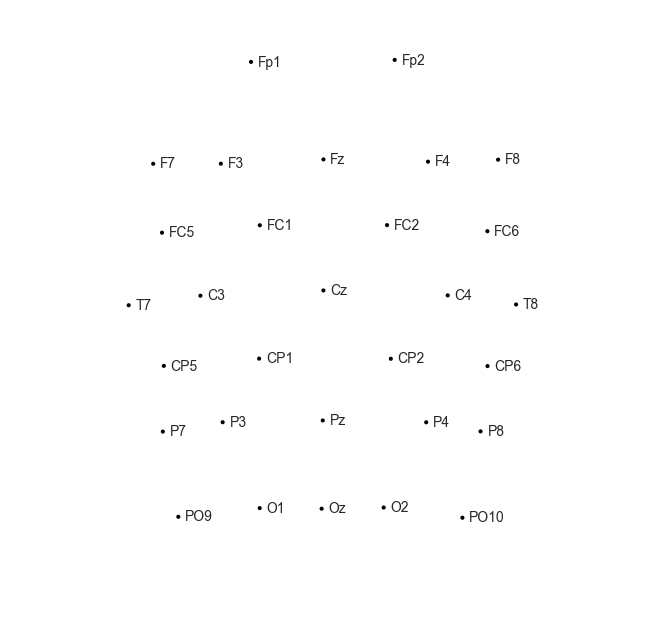

In [22]:
print("\nStep 2: Converting data to MNE Epochs format...")

n_interactions, n_channels, n_samples = preprocessed_data.shape

ch_names = [
    'Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6',
    'T7', 'C3', 'Cz', 'C4', 'T8', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3',
    'Pz', 'P4', 'P8', 'PO9', 'O1', 'Oz', 'O2', 'PO10'
]
assert len(ch_names) == n_channels, "Channel name mismatch"
ch_types = ['eeg'] * n_channels
sfreq = SAMPLING_RATE_DOWNSAMPLED

info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
montage = mne.channels.make_standard_montage('standard_1020')
info.set_montage(montage, on_missing='warn')

epochs = mne.EpochsArray(preprocessed_data, info, tmin=-10.0)
print(epochs)

# Apply Common Average Reference using MNE's built-in method
epochs.set_eeg_reference('average', projection=True)
print("Common Average Reference (CAR) has been added as a projector.")

# **FIX 2: Apply the projector now so ICLabel can see the CAR data**
epochs.apply_proj()
print("CAR projector has been applied to the data.")


print("Plotting sensor locations for verification...")
sensor_plot = epochs.plot_sensors(show_names=True, show=False)
# sensor_plot.suptitle("Verify these are your electrode locations", y=0.95)

In [5]:
print("\nStep 3: Fitting ICA model...")

num_trials_for_ica_fit = 2
print(f"Using the first {num_trials_for_ica_fit} trials to fit the ICA model.")

# **FIX 3: Use extended infomax version of picard for best ICLabel results**
ica = mne.preprocessing.ICA(
    n_components=n_channels - 1,
    method='picard',
    fit_params=dict(ortho=False, extended=True), # Added for better compatibility
    max_iter='auto',
    random_state=97
)

# High-pass filter a COPY of the data just for the ICA fit
print("Applying a 1.0 Hz high-pass filter for ICA fitting...")
epochs_for_ica_fit = epochs[:num_trials_for_ica_fit].copy().filter(l_freq=1.0, h_freq=None)

# Fit ICA on the high-passed subset of data
ica.fit(epochs_for_ica_fit)
print("ICA model has been fitted.")


Step 3: Fitting ICA model...
Using the first 2 trials to fit the ICA model.
Applying a 1.0 Hz high-pass filter for ICA fitting...
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)

Fitting ICA to data using 30 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 29 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 1.3s.
ICA model has been fitted.


In [6]:
print("\nStep 4: Classifying components with ICLabel...")
labels_dict = label_components(epochs, ica, method='iclabel')
ica.labels_ = labels_dict  # store for convenience

print("ICLabel classifications:")
for i, label in enumerate(ica.labels_['labels']):
    print(f"  Component {i:02d}: {label}")


Step 4: Classifying components with ICLabel...


/var/folders/8g/lw57w3cx1zd7z20y9l937bx40000gn/T/ipykernel_43830/3741501195.py:2: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  labels_dict = label_components(epochs, ica, method='iclabel')
/var/folders/8g/lw57w3cx1zd7z20y9l937bx40000gn/T/ipykernel_43830/3741501195.py:2: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  labels_dict = label_components(epochs, ica, method='iclabel')


ICLabel classifications:
  Component 00: eye blink
  Component 01: muscle artifact
  Component 02: heart beat
  Component 03: eye blink
  Component 04: heart beat
  Component 05: brain
  Component 06: brain
  Component 07: brain
  Component 08: brain
  Component 09: muscle artifact
  Component 10: other
  Component 11: brain
  Component 12: brain
  Component 13: brain
  Component 14: brain
  Component 15: heart beat
  Component 16: muscle artifact
  Component 17: brain
  Component 18: other
  Component 19: brain
  Component 20: brain
  Component 21: other
  Component 22: brain
  Component 23: other
  Component 24: other
  Component 25: muscle artifact
  Component 26: brain
  Component 27: muscle artifact
  Component 28: other


In [7]:
print("\nStep 5: Identifying artifact components to remove...")
labels = ica.labels_['labels']
exclude_indices = [idx for idx, label in enumerate(labels) if label not in ['brain', 'other']]
print(f"Found {len(exclude_indices)} artifact components to exclude.")
print(f"Excluding component indices: {exclude_indices}")
ica.exclude = exclude_indices


Step 5: Identifying artifact components to remove...
Found 10 artifact components to exclude.
Excluding component indices: [0, 1, 2, 3, 4, 9, 15, 16, 25, 27]


In [8]:
print("\nStep 6: Applying ICA to clean all 200 trials...")

# The CAR projector was already applied in Step 2, so no need to do it again here.
epochs_cleaned = ica.apply(epochs.copy())
print("Artifacts have been removed from the entire dataset.")


Step 6: Applying ICA to clean all 200 trials...
Applying ICA to Epochs instance
    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (29 components)
    Zeroing out 10 ICA components
    Projecting back using 30 PCA components
Artifacts have been removed from the entire dataset.



Step 7: Visualizing results...

Shape of final cleaned data (NumPy): (200, 30, 5000)


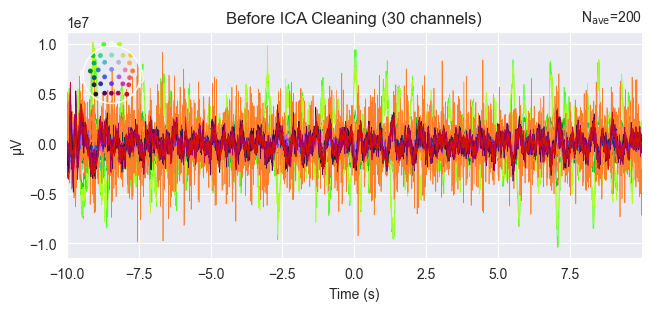

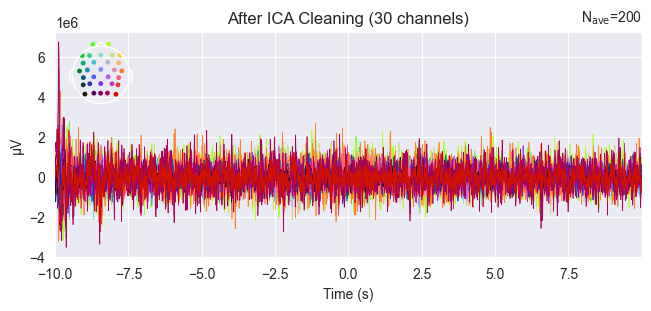

In [9]:
print("\nStep 7: Visualizing results...")

evoked_before = epochs.average()
evoked_after = epochs_cleaned.average()

fig_before = evoked_before.plot(titles='Before ICA Cleaning', show=False, window_title="Before ICA")
fig_after = evoked_after.plot(titles='After ICA Cleaning', show=False, window_title="After ICA")

cleaned_data_numpy = epochs_cleaned.get_data(copy=True)
print(f"\nShape of final cleaned data (NumPy): {cleaned_data_numpy.shape}")

plt.show()

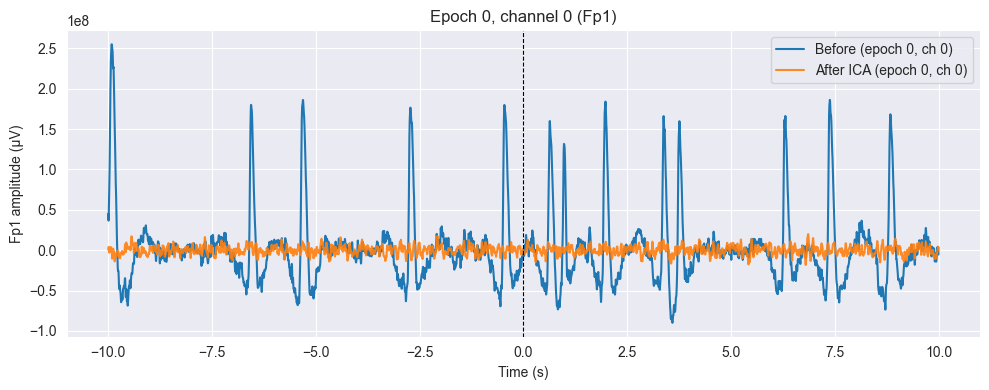

In [12]:
epoch_idx = 0   # "0th subject" interpreted as first epoch
ch_idx = 0     # "0th electrode"
ch_name = epochs.ch_names[ch_idx]  # e.g., 'Fp1' given your montage [web:26]

# Time axis for epochs (in seconds)
times = epochs.times  # length == n_times, aligned to tmin specified in EpochsArray [web:26][web:27]

# Extract data arrays (Volts by convention in MNE)
before = epochs.get_data(copy=True)[epoch_idx, ch_idx, :]            # shape (n_times,) [web:26]
after = epochs_cleaned.get_data(copy=True)[epoch_idx, ch_idx, :]     # shape (n_times,) [web:26]

# Optional: convert to microvolts for readability
scale_to_uV = True
if scale_to_uV:
    before = before * 1e6
    after = after * 1e6
    ylab = f"{ch_name} amplitude (µV)"
else:
    ylab = f"{ch_name} amplitude (V)"

plt.figure(figsize=(10, 4))
plt.plot(times, before, label="Before (epoch 0, ch 0)")
plt.plot(times, after, label="After ICA (epoch 0, ch 0)", alpha=0.9)
plt.axvline(0, color="k", lw=0.8, ls="--")
plt.xlabel("Time (s)")
plt.ylabel(ylab)
plt.title(f"Epoch {epoch_idx}, channel {ch_idx} ({ch_name})")
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
from scipy.signal import welch
from scipy.integrate import simpson

In [14]:
def calculate_psd_features(eeg_data, sfreq=250):
    print("\nStep 8: Starting Feature Engineering - Calculating PSD...")

    # Define the frequency bands of interest
    BANDS = {
        "delta": [1, 4],
        "theta": [4, 8],
        "alpha": [8, 13],
        "beta": [13, 30],
        "gamma": [30, 45], # Upper limit matches our band-pass filter
    }
    band_names = list(BANDS.keys())

    # Get the dimensions of the input data
    n_epochs, n_channels, _ = eeg_data.shape

    # Initialize an array to store the features
    psd_features = np.zeros((n_epochs, n_channels, len(BANDS)))

    # Define parameters for the Welch method
    # A 2-second window with 50% overlap is a robust choice
    nperseg = 2 * sfreq
    noverlap = nperseg // 2

    # Iterate over each epoch (interaction/trial)
    for epoch_idx in range(n_epochs):
        # Iterate over each channel
        for ch_idx in range(n_channels):
            # Extract the signal for the current epoch and channel
            signal = eeg_data[epoch_idx, ch_idx, :]

            # Calculate the PSD using the Welch method
            freqs, psd = welch(signal, fs=sfreq, nperseg=nperseg, noverlap=noverlap)

            # Calculate the absolute power for each frequency band
            for i, band in enumerate(BANDS.values()):
                # Find the indices of frequencies that fall within the current band
                idx_band = np.logical_and(freqs >= band[0], freqs <= band[1])

                # Integrate the PSD over the band to find the total power
                # using Simpson's rule for a more accurate area calculation.
                band_power = simpson(psd[idx_band], freqs[idx_band]) # Changed 'simps' to 'simpson'
                psd_features[epoch_idx, ch_idx, i] = band_power

    print("PSD feature calculation complete.")
    return psd_features, band_names


Step 8: Starting Feature Engineering - Calculating PSD...
PSD feature calculation complete.

--- Feature Engineering Results ---
Shape of the final feature matrix: (200, 30, 5)
The last dimension corresponds to the bands: ['delta', 'theta', 'alpha', 'beta', 'gamma']

Example features for Trial 0, Channel 0 (Fp1):
  - Delta power: 6.8505
  - Theta power: 6.5955
  - Alpha power: 8.3051
  - Beta power: 4.7835
  - Gamma power: 1.5179


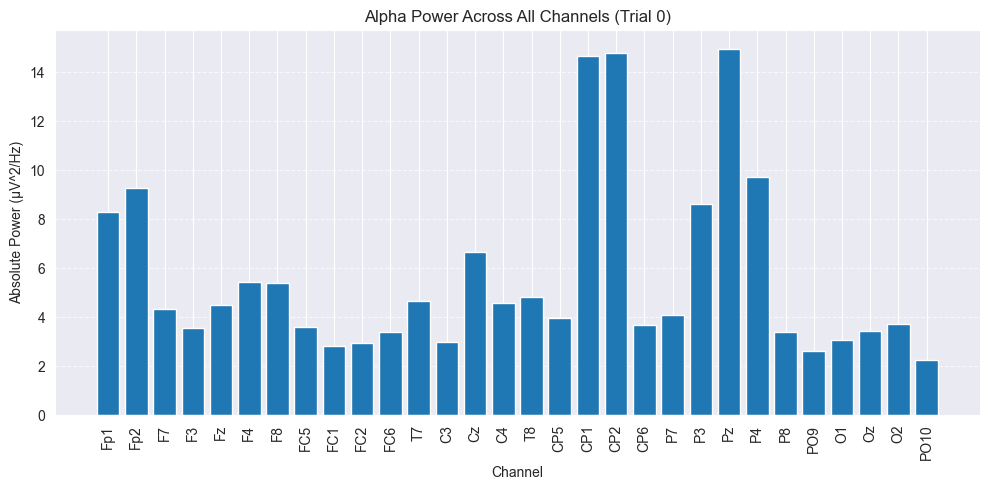

In [15]:
eeg_features, band_names = calculate_psd_features(cleaned_data_numpy, sfreq=SAMPLING_RATE_DOWNSAMPLED)

print("\n--- Feature Engineering Results ---")
print(f"Shape of the final feature matrix: {eeg_features.shape}")
print(f"The last dimension corresponds to the bands: {band_names}")

# Print the features for the first trial, first channel to verify
print(f"\nExample features for Trial 0, Channel 0 ({ch_names[0]}):")
for i, name in enumerate(band_names):
    print(f"  - {name.capitalize()} power: {eeg_features[0, 0, i]:.4f}")

# Optional: Visualize the features for one trial
plt.figure(figsize=(10, 5))
# Let's visualize the Alpha power across all channels for the first trial
alpha_band_index = band_names.index('alpha')
alpha_power_trial0 = eeg_features[0, :, alpha_band_index]

plt.bar(ch_names, alpha_power_trial0)
plt.title('Alpha Power Across All Channels (Trial 0)')
plt.xlabel('Channel')
plt.ylabel('Absolute Power (μV^2/Hz)')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [16]:
eeg_features.shape

(200, 30, 5)

In [17]:
# Save eeg_features to a pickle file for model training
import pickle
print("\nStep 9: Saving EEG features to pickle file...")

# Create a dictionary to save both the features and metadata
eeg_data_dict = {
    'features': eeg_features,
    'band_names': band_names,
    'channel_names': ch_names,
    'sampling_rate': SAMPLING_RATE_DOWNSAMPLED,
    'shape_info': {
        'n_epochs': eeg_features.shape[0],
        'n_channels': eeg_features.shape[1],
        'n_bands': eeg_features.shape[2]
    }
}

# Save to pickle file
pickle_filename = 'eeg_features.pkl'
with open(pickle_filename, 'wb') as f:
    pickle.dump(eeg_data_dict, f)

print(f"EEG features saved to '{pickle_filename}'")
print(f"Saved data contains:")
print(f"  - features: {eeg_features.shape}")
print(f"  - band_names: {band_names}")
print(f"  - channel_names: {len(ch_names)} channels")
print(f"  - sampling_rate: {SAMPLING_RATE_DOWNSAMPLED} Hz")

# Example of how to load the data in another file:
print(f"\nTo load this data in another file, use:")
print(f"import pickle")
print(f"with open('{pickle_filename}', 'rb') as f:")
print(f"    data = pickle.load(f)")
print(f"features = data['features']")
print(f"band_names = data['band_names']")
print(f"channel_names = data['channel_names']")


Step 9: Saving EEG features to pickle file...
EEG features saved to 'eeg_features.pkl'
Saved data contains:
  - features: (200, 30, 5)
  - band_names: ['delta', 'theta', 'alpha', 'beta', 'gamma']
  - channel_names: 30 channels
  - sampling_rate: 250 Hz

To load this data in another file, use:
import pickle
with open('eeg_features.pkl', 'rb') as f:
    data = pickle.load(f)
features = data['features']
band_names = data['band_names']
channel_names = data['channel_names']


(200, 30, 5)

In [45]:
print("\nStep 10: Loading and processing EEG labels...")

# Load the label file
label_location = "/Users/anuraagsrivatsa/Documents/Capstone/EAV/EAV/subject1/EEG/subject1_eeg_label.mat"
label_data = scipy.io.loadmat(label_location)

# Extract the label array (assuming it's stored in a key like 'label' or similar)
# Let's check what keys are available in the .mat file
print("Available keys in label file:", list(label_data.keys()))


Step 10: Loading and processing EEG labels...
Available keys in label file: ['__header__', '__version__', '__globals__', 'label']


In [46]:


labels_original = label_data['label']
print(f"Original label shape: {labels_original.shape}")

# Transpose from (10, 200) to (200, 10)
labels_transposed = labels_original.T
print(f"Transposed label shape: {labels_transposed.shape}")

# Handle duplication by combining duplicate categories
# Original: 10 categories with duplicates
# New: 5 categories (neutral, sadness, anger, happiness, calmness)
n_trials, n_original_categories = labels_transposed.shape
n_new_categories = 5

# Create new label array
labels_processed = np.zeros((n_trials, n_new_categories))

# Define the mapping from original indices to new indices
category_mapping = {
    0: 0,  # neutral (0th index) -> 0
    1: 0,  # neutral (1st index) -> 0 (combine with 0th)
    2: 1,  # sadness (2nd index) -> 1
    3: 1,  # sadness (3rd index) -> 1 (combine with 2nd)
    4: 2,  # anger (4th index) -> 2
    5: 2,  # anger (5th index) -> 2 (combine with 4th)
    6: 3,  # happiness (6th index) -> 3
    7: 3,  # happiness (7th index) -> 3 (combine with 6th)
    8: 4,  # calmness (8th index) -> 4
    9: 4,  # calmness (9th index) -> 4 (combine with 8th)
}

# Process each trial
for trial_idx in range(n_trials):
    for orig_cat_idx in range(n_original_categories):
        if labels_transposed[trial_idx, orig_cat_idx] == 1:  # If this category is active
            new_cat_idx = category_mapping[orig_cat_idx]
            labels_processed[trial_idx, new_cat_idx] = 1

print(f"Processed label shape: {labels_processed.shape}")

# Define category names for metadata
category_names = ['neutral', 'sadness', 'anger', 'happiness', 'calmness']

# Verify the processing worked correctly
print("\nLabel processing verification:")
for i in range(min(5, n_trials)):  # Show first 5 trials
    orig_active = np.where(labels_transposed[i, :] == 1)[0]
    new_active = np.where(labels_processed[i, :] == 1)[0]
    orig_cats = [f"orig_{idx}" for idx in orig_active]
    new_cats = [category_names[idx] for idx in new_active]
    print(f"Trial {i}: {orig_cats} -> {new_cats}")


Original label shape: (10, 200)
Transposed label shape: (200, 10)
Processed label shape: (200, 5)

Label processing verification:
Trial 0: ['orig_0'] -> ['neutral']
Trial 1: ['orig_1'] -> ['neutral']
Trial 2: ['orig_4'] -> ['anger']
Trial 3: ['orig_5'] -> ['anger']
Trial 4: ['orig_4'] -> ['anger']


In [47]:
print("\nStep 11: Saving processed labels to pickle file...")

# Create a dictionary to save the labels and metadata
label_data_dict = {
    'labels': labels_processed,
    'category_names': category_names,
    'original_shape': labels_original.shape,
    'processed_shape': labels_processed.shape,
    'category_mapping': category_mapping,
    'description': 'One-hot encoded emotion labels: neutral, sadness, anger, happiness, calmness',
    'processing_info': {
        'original_categories': 10,
        'processed_categories': 5,
        'duplicate_handling': 'Combined duplicate emotion categories',
        'shape_transformation': 'Transposed from (10, 200) to (200, 5)'
    }
}

# Save to pickle file
label_pickle_filename = 'eeg_labels.pkl'
with open(label_pickle_filename, 'wb') as f:
    pickle.dump(label_data_dict, f)

print(f"EEG labels saved to '{label_pickle_filename}'")
print(f"Saved data contains:")
print(f"  - labels: {labels_processed.shape}")
print(f"  - category_names: {category_names}")
print(f"  - original_shape: {labels_original.shape}")
print(f"  - processed_shape: {labels_processed.shape}")

# Verify label distribution
print(f"\nLabel distribution across {n_trials} trials:")
for i, cat_name in enumerate(category_names):
    count = np.sum(labels_processed[:, i])
    print(f"  - {cat_name}: {count} trials ({count/n_trials*100:.1f}%)")

# Example of how to load the data in another file:
print(f"\nTo load this data in another file, use:")
print(f"import pickle")
print(f"with open('{label_pickle_filename}', 'rb') as f:")
print(f"    label_data = pickle.load(f)")
print(f"labels = label_data['labels']")
print(f"category_names = label_data['category_names']")



Step 11: Saving processed labels to pickle file...
EEG labels saved to 'eeg_labels.pkl'
Saved data contains:
  - labels: (200, 5)
  - category_names: ['neutral', 'sadness', 'anger', 'happiness', 'calmness']
  - original_shape: (10, 200)
  - processed_shape: (200, 5)

Label distribution across 200 trials:
  - neutral: 40.0 trials (20.0%)
  - sadness: 40.0 trials (20.0%)
  - anger: 40.0 trials (20.0%)
  - happiness: 40.0 trials (20.0%)
  - calmness: 40.0 trials (20.0%)

To load this data in another file, use:
import pickle
with open('eeg_labels.pkl', 'rb') as f:
    label_data = pickle.load(f)
labels = label_data['labels']
category_names = label_data['category_names']
